## Generating point cloud

DO NOT RUN if results are already present, as it takes 40 minutes

In [ ]:
from pyodm import Node
from os import listdir, path

In [ ]:
n = Node('localhost', 3000)

In [ ]:
prefix = '../images/original'
files = [path.sep.join([prefix, f]) for f in listdir(prefix)]

In [ ]:
task = n.create_task(files, {'dsm': True})
task.wait_for_completion()

In [ ]:
task.download_assets("/media/antonio/Ubuntail/Dropbox/education/phd/courses/processamento_imagens/assignments/final/pyodm")

## Visualizing point cloud

In [ ]:
import laspy
import open3d as o3d
import numpy as np
from os import listdir, path

In [ ]:
pc_data_dir = '/media/antonio/Ubuntail/Dropbox/education/phd/courses/processamento_imagens/assignments/final/pyodm/entwine_pointcloud/ept-data'

In [ ]:
points = None
for fname in listdir(pc_data_dir):
    pc = laspy.read(path.sep.join([pc_data_dir, fname]))
    point_data = np.stack([pc.X, pc.Y, pc.Z], axis=0).transpose((1, 0))
    if points is None:
        points = point_data
    else:
        points = np.concatenate([points, point_data])
points = points.astype(np.float32)       

In [ ]:
surface = o3d.geometry.PointCloud()
surface.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([surface])

## Generate Depth-Map from Point-Cloud

In [ ]:
from point_cloud_tools import get_depth_and_rgb
from img_utils import show

In [ ]:
pc_data_dir = '/media/antonio/Ubuntail/Dropbox/education/phd/courses/processamento_imagens/assignments/final/pyodm/entwine_pointcloud/ept-data'

In [ ]:
depth_map, rgb = get_depth_and_rgb(pc_data_dir, (500, 625))

In [ ]:
show(depth_map)
show(rgb)

## Segmentation Using Depth Map

In [2]:
import numpy as np
from os import listdir, path
import cv2
from skimage.morphology import disk

from point_cloud_tools import get_depth_and_rgb
from img_utils import normalize, show
from segmentation import segment_by_depth

In [3]:
base_dir = '/media/antonio/Ubuntail/Dropbox/education/phd/courses/processamento_imagens/assignments/final'
main_img_path = path.sep.join([base_dir, 'images', 'mataDS.tif'])

p_cloud_dir = path.sep.join([base_dir, 'pyodm', 'entwine_pointcloud', 'ept-data'])

In [4]:
downscaling = 4
main_img = cv2.imread(main_img_path)
main_img = cv2.resize(main_img, (main_img.shape[1] // downscaling, main_img.shape[0] // downscaling))
resolution = main_img.shape[:2]

(4091, 6217)


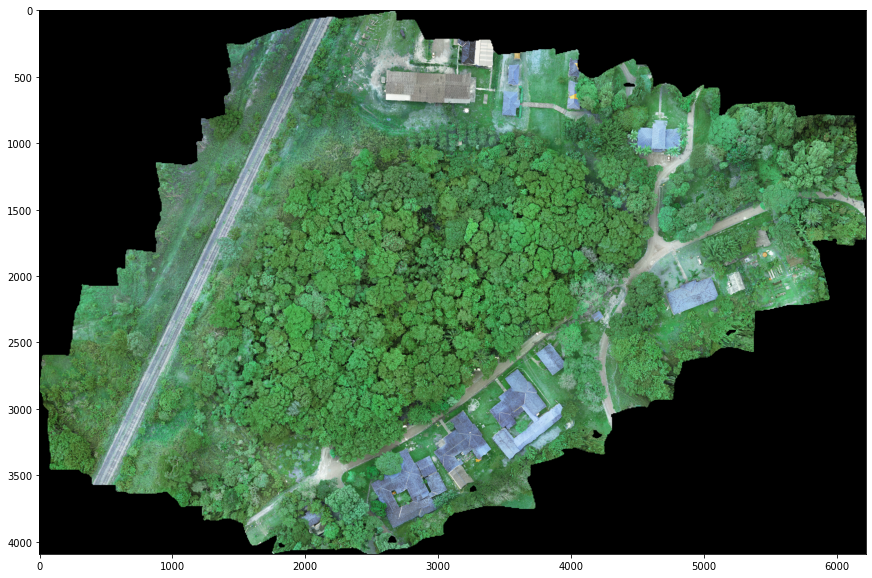

In [5]:
show(main_img)
print(resolution)

In [6]:
depth_map, _ = get_depth_and_rgb(p_cloud_dir, resolution)

(4091, 6217)
(4091, 6217, 3)


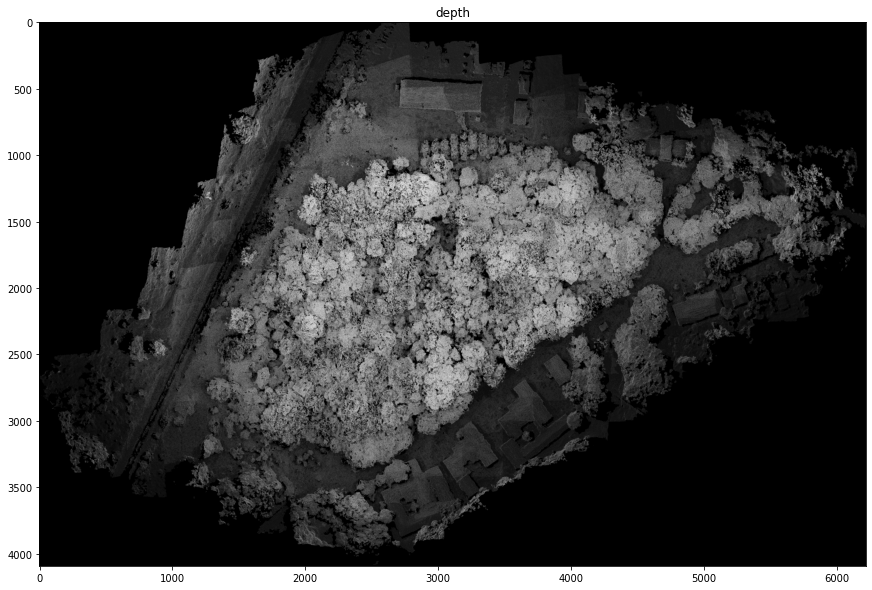

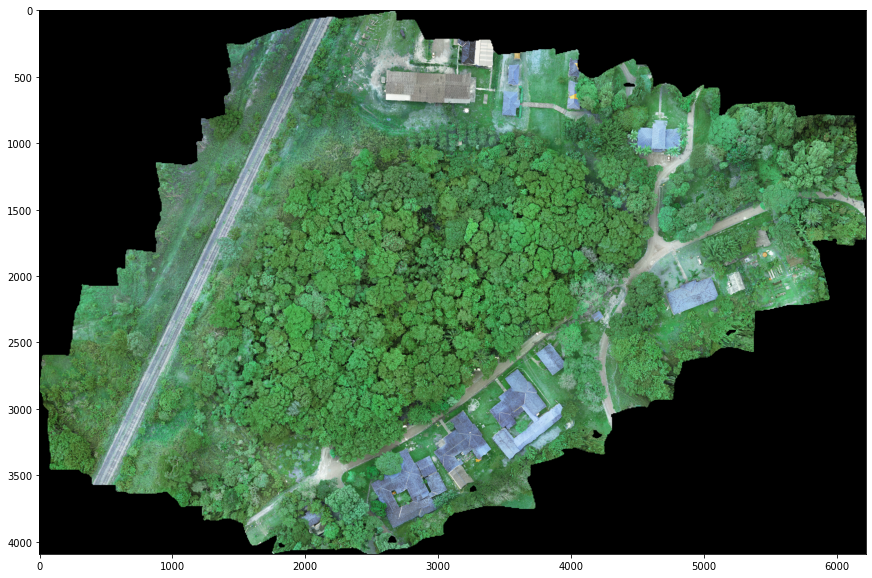

In [27]:
show(depth_map)
print(depth_map.shape)
show(main_img)
print(main_img.shape)

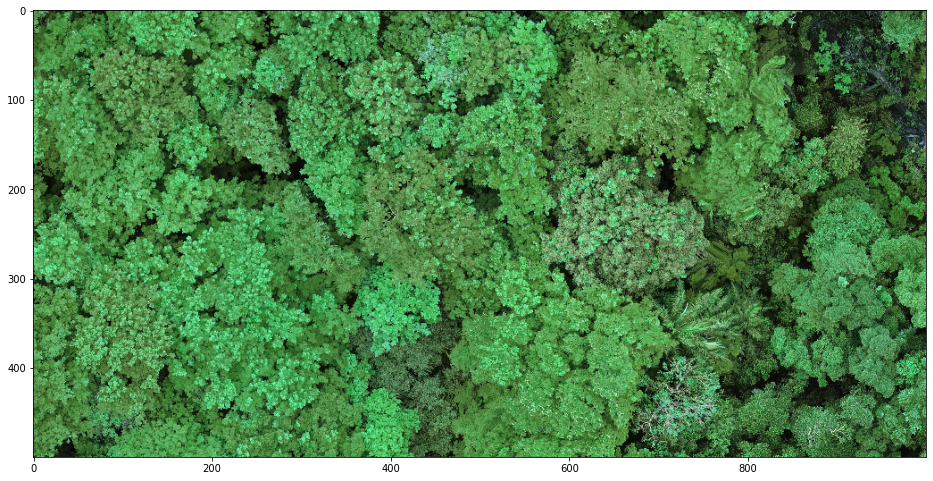

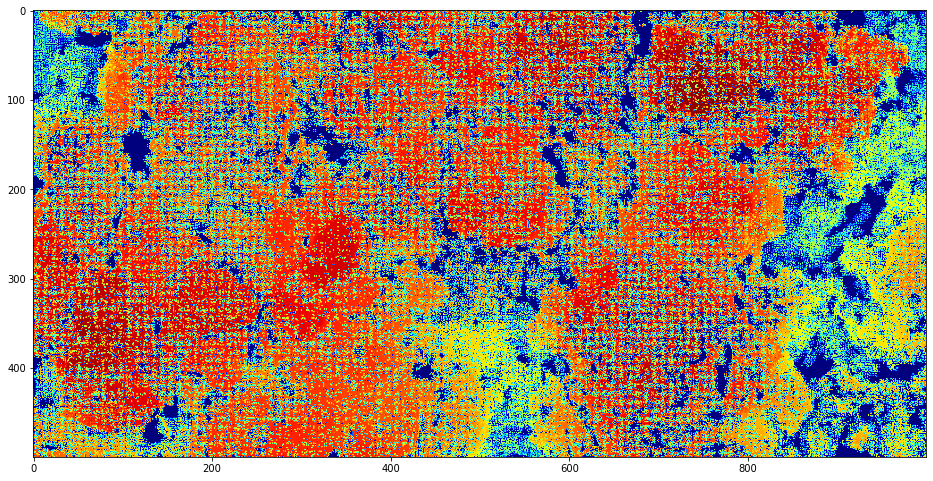

In [8]:
h_head, h_tail = 1500, 2000
w_head, w_tail = 2000, 3000

crop_rgb = main_img[h_head:h_tail, w_head:w_tail].copy()
crop_depth = depth_map[h_head:h_tail, w_head:w_tail].copy()

gaps = np.where(np.all(crop_rgb == (-1, -1, -1), axis=-1))
crop_rgb[gaps] = (0, 0, 0)
crop_rgb = normalize(crop_rgb, (0, 255), np.uint8)

show(crop_rgb)
show(crop_depth, cmap='jet')

In [22]:
ws, inter = segment_by_depth(crop_rgb, crop_depth, structuring_el=disk(45), return_intermediate=True)

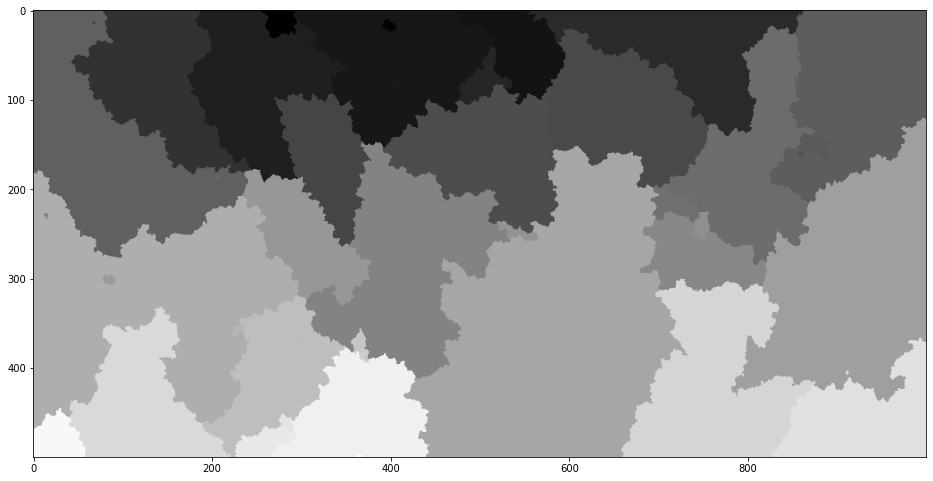

In [24]:
show(ws)

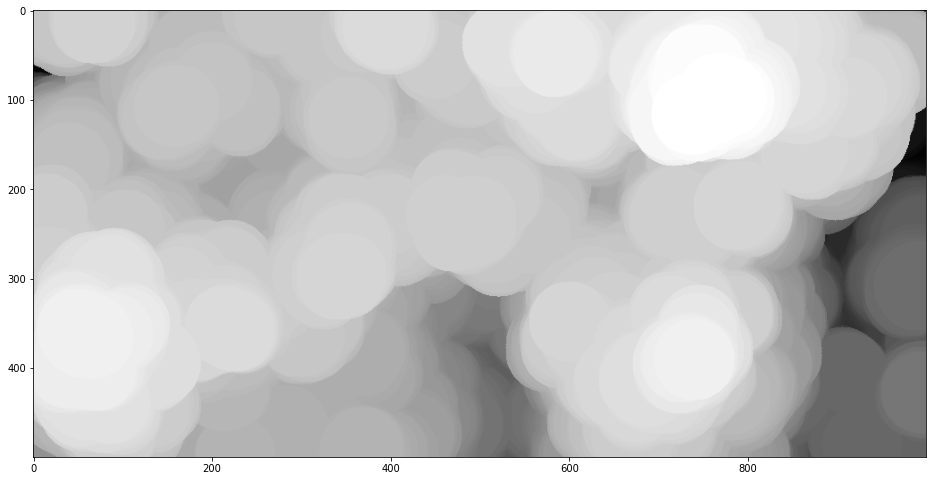

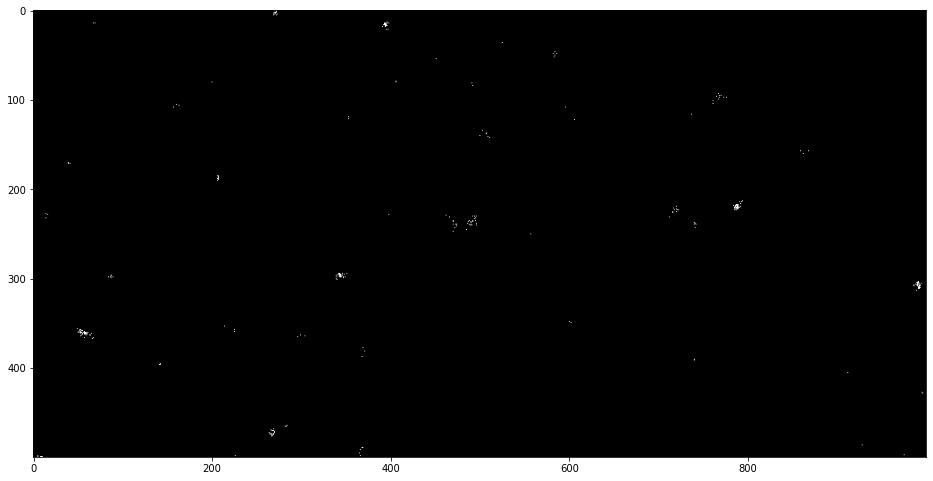

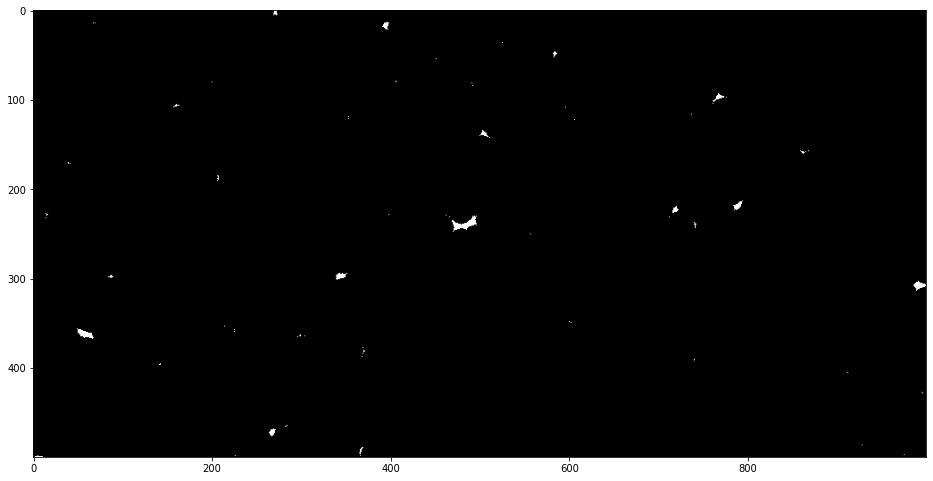

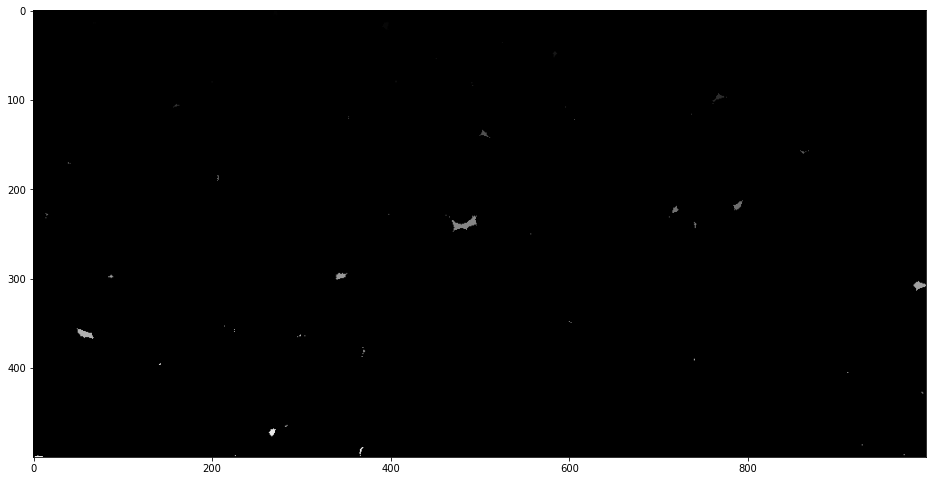

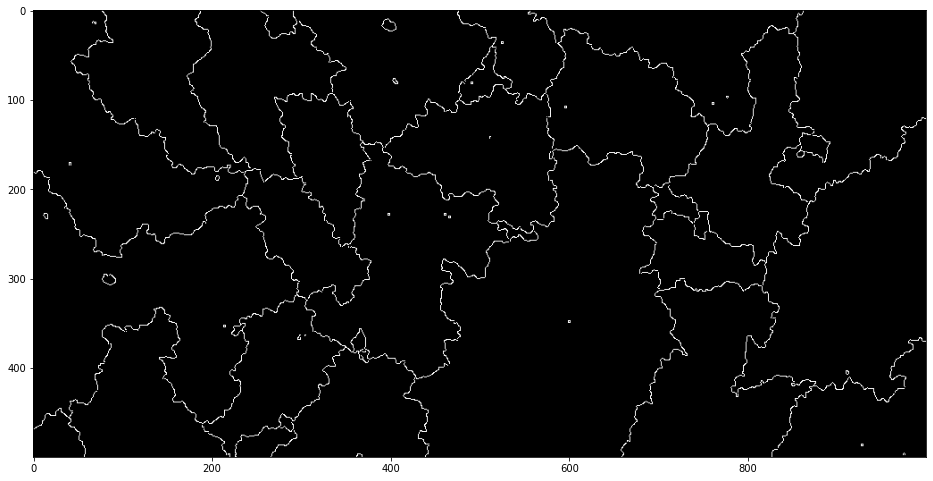

In [25]:
for k in inter:
    show(inter[k], title=k)